### Stacked Cross-Validated RF + XGBoost model to predict Crypto close price direction over next 15 min

In [1]:
import subprocess

bashCommand = "curl ipecho.net/plain"
#process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
stdoutdata = subprocess.getoutput(bashCommand)
output = stdoutdata.split()[-1]
bash_comm_2 = "curl https://ipinfo.io/"+output
stdoutdata = subprocess.getoutput(bash_comm_2)

if "US" in stdoutdata:
    raise ValueError("Server in US blocks binance\n Disconnect and delete runtime")

In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/sats4u/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%%capture
! pip install -r requirements.txt

In [4]:
! pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import backtrader as bt
from backtrader.feeds import PandasData
import pyfolio as pf
from pathlib import Path
import csv

/usr/local/lib/python3.9/dist-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [6]:
import json
import sys
import pandas as pd
import numpy as np
import math
from datetime import datetime
import time
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
import src.loadcrypto as lc
import src.featbuild as fb
import src.candles2timeseries as c2t
import src.sats2model as s2m
import src.timeutils as tu
import src.sats2backtest as s2b
import shap

from sklearn.metrics import r2_score, roc_auc_score
import tensorflow.keras.backend as K
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# settings for reproducible results
#os.environ['CUDA_VISIBLE_DEVICES'] = ''
np.random.seed(420)
os.environ['PYTHONHASHSEED'] = '0'
tf.random.set_seed(420)

## Load Asset Details, Binance client data and Download 15m candles from Binance

In [7]:
data_folder = "data/"
asset_details = pd.read_csv(data_folder + 'asset_details.csv')

In [8]:
secret_data_folder = '/content/drive/MyDrive/Colab Notebooks/crypto_project/crypto_data/'
secrets_filename = secret_data_folder+'data.json'

In [9]:
crypto = lc.CryptoData(asset_details,data_folder)
crypto.load_binance_client(secrets_filename,data1_str = 'DATA1',data2_str = 'DATA2i')
crypto.trade_time_units(dt=60,kline_size="15m",period=15,starting_date = '1 Mar 2017')

In [10]:
tickers=crypto.asset_details["Ticker"]
tickers = list(tickers[tickers=='ETHUSDT'].values)

In [11]:
ldata_df = crypto.load_cryptos(tickers,save = True)                             

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


All caught up..!
size of dataset: (195143, 8)


In [12]:
crypto.asset_details

,Asset_ID,Weight,Asset_Name,Ticker
0,2,2.397895,Bitcoin Cash,BCHUSDT
1,0,4.304065,Binance Coin,BNBUSDT
2,1,6.779922,Bitcoin,BTCUSDT
3,5,1.386294,EOS.IO,EOSUSDT
4,7,2.079442,Ethereum Classic,ETCUSDT
5,6,5.894403,Ethereum,ETHUSDT
6,9,2.397895,Litecoin,LTCUSDT
7,11,1.609438,Monero,XMRUSDT
8,13,1.791759,TRON,TRXUSDT
9,12,2.079442,Stellar,XLMUSDT


### Plot wick Candles and build features from technical analysis

In [13]:
target = "UpDown"
crypto_name = "Ethereum" #Bitcoin
crypto = fb.Candles(ldata_df,crypto_name, target = target)
crypto.candles

,Low,High,Open,Close,Volume
Date,,,,,
2017-08-17 04:00:00,298.00,301.13,301.13,298.00,5.80167
2017-08-17 04:15:00,298.00,300.80,298.00,299.39,31.44065
2017-08-17 04:30:00,299.39,300.79,299.39,299.60,52.93579
2017-08-17 04:45:00,299.60,302.57,299.60,301.61,35.49066
2017-08-17 05:00:00,300.95,302.57,301.61,302.01,81.69235
...,...,...,...,...,...
2023-03-17 16:30:00,1710.00,1721.96,1718.02,1714.48,6038.88320
2023-03-17 16:45:00,1710.22,1717.13,1714.49,1712.18,4257.78070
2023-03-17 17:00:00,1712.17,1732.47,1712.17,1728.01,9628.59620


The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


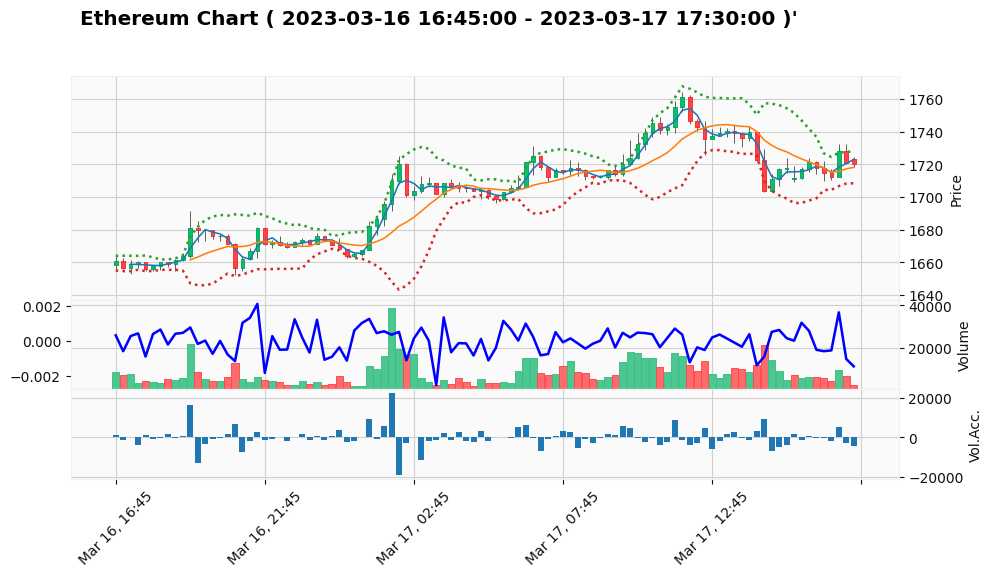

In [14]:
crypto.buildfeatures()
crypto.ta_fullplot()

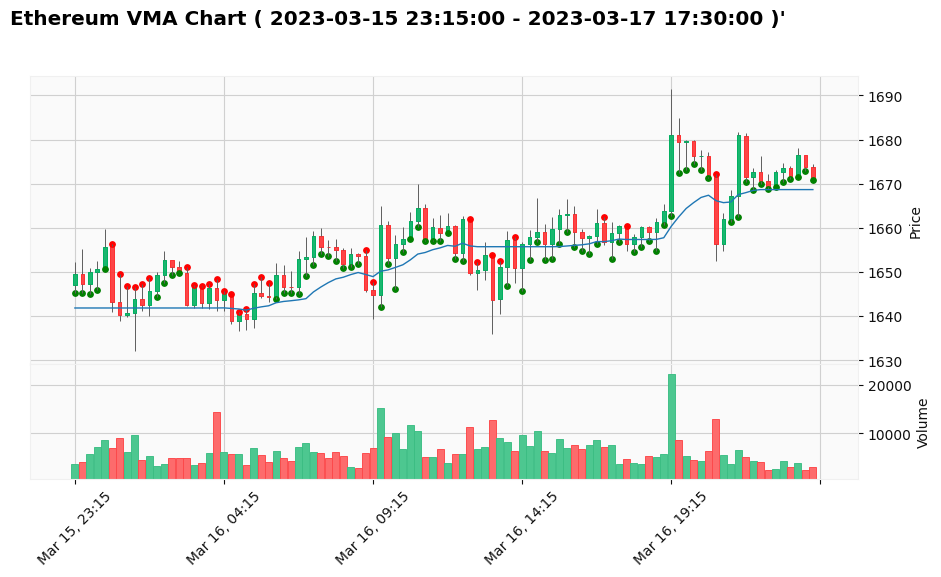

In [15]:
crypto.ta_vma_plot(in_step = -170,last_step = -70, ma_window = 0)

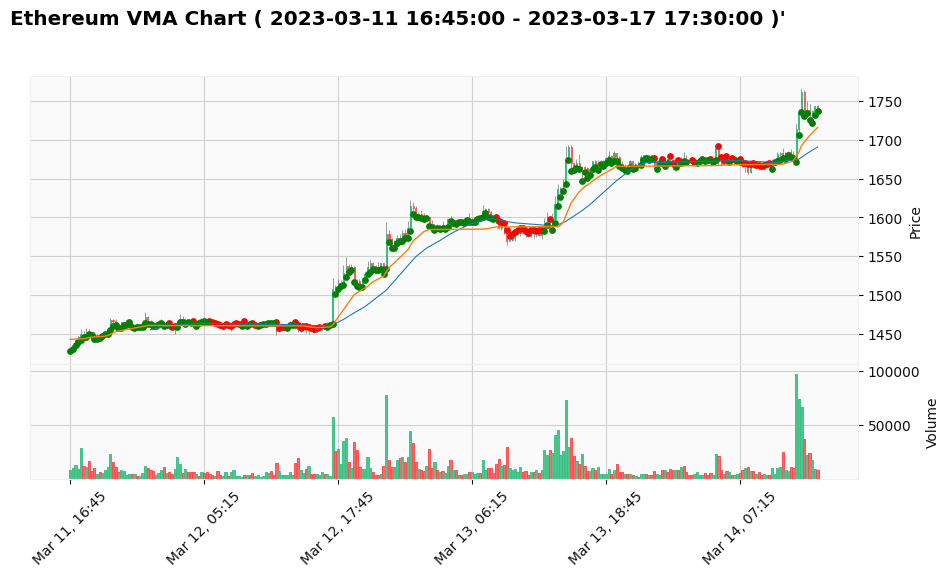

In [16]:
crypto.ta_vma_plot(in_step = -580,last_step = -300, ma_window = 31)

In [17]:
def moving_average(x, n, type='simple'):
        """
        compute an n period moving average.
    
        type is 'simple' | 'exponential'
    
        """
        x = np.asarray(x)
        if type == 'simple':
            weights = np.ones(n)
        else:
            weights = np.exp(np.linspace(-1., 0., n))
    
        weights /= weights.sum()
    
        a = np.convolve(x, weights, mode='full')[:len(x)]
        a[:n] = a[n]
        return a
    
    
def relative_strength(prices, n=14):
    """
    compute the n period relative strength indicator
    http://stockcharts.com/school/doku.php?id=chart_school:glossary_r#relativestrengthindex
    http://www.investopedia.com/terms/r/rsi.asp
    """

    deltas = np.diff(prices)
    seed = deltas[:n + 1]
    up = seed[seed >= 0].sum() / n
    down = -seed[seed < 0].sum() / n
    rs = up / down
    rsi = np.zeros_like(prices)
    rsi[:n] = 100. - 100. / (1. + rs)

    for i in range(n, len(prices)):
        delta = deltas[i - 1]  # cause the diff is 1 shorter

        if delta > 0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta

        up = (up * (n - 1) + upval) / n
        down = (down * (n - 1) + downval) / n

        rs = up / down
        rsi[i] = 100. - 100. / (1. + rs)

    return rsi

def moving_average_convergence(x, nslow=26, nfast=12):
    """
    compute the MACD (Moving Average Convergence/Divergence) using a fast and
    slow exponential moving avg

    return value is emaslow, emafast, macd which are len(x) arrays
    """
    emaslow = moving_average(x, nslow, type='exponential')
    emafast = moving_average(x, nfast, type='exponential')
    return emaslow, emafast, emafast - emaslow

def weighted_moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return np.append(np.array([1]*n), ret[n - 1:] / n)[1:]

#@jit(nopython=True)
def calcHullMA_inference(series, N=50):
    SMA1 = weighted_moving_average(series, N)
    SMA2 = weighted_moving_average(series, int(N/2))
    res = (2 * SMA2 - SMA1)
    return np.mean(res[-int(np.sqrt(N)):])

    #row["hull"] = last_close - calcHullMA_inference(f[asset]["all_close"][-260:], 240)

def WMA(s, period):
       return s.rolling(period).apply(lambda x: ((np.arange(period)+1)*x).sum()/(np.arange(period)+1).sum(), raw=True)

def HMA(s, period):
       return WMA(WMA(s, period//2).multiply(2).sub(WMA(s, period)), int(np.sqrt(period)))

In [18]:
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class GroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_size : int, default=None
        Maximum size for a single training set.
    Examples
    --------
    >>> import numpy as np
    >>> from sklearn.model_selection import GroupTimeSeriesSplit
    >>> groups = np.array(['a', 'a', 'a', 'a', 'a', 'a',\
                           'b', 'b', 'b', 'b', 'b',\
                           'c', 'c', 'c', 'c',\
                           'd', 'd', 'd'])
    >>> gtss = GroupTimeSeriesSplit(n_splits=3)
    >>> for train_idx, test_idx in gtss.split(groups, groups=groups):
    ...     print("TRAIN:", train_idx, "TEST:", test_idx)
    ...     print("TRAIN GROUP:", groups[train_idx],\
                  "TEST GROUP:", groups[test_idx])
    TRAIN: [0, 1, 2, 3, 4, 5] TEST: [6, 7, 8, 9, 10]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a']\
    TEST GROUP: ['b' 'b' 'b' 'b' 'b']
    TRAIN: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] TEST: [11, 12, 13, 14]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a' 'b' 'b' 'b' 'b' 'b']\
    TEST GROUP: ['c' 'c' 'c' 'c']
    TRAIN: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]\
    TEST: [15, 16, 17]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a' 'b' 'b' 'b' 'b' 'b' 'c' 'c' 'c' 'c']\
    TEST GROUP: ['d' 'd' 'd']
    """
    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_size=None
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_size = max_train_size

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))
        group_test_size = n_groups // n_folds
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []
            for train_group_idx in unique_groups[:group_test_start]:
                train_array_tmp = group_dict[train_group_idx]
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)
            train_end = train_array.size
            if self.max_train_size and self.max_train_size < train_end:
                train_array = train_array[train_end -
                                          self.max_train_size:train_end]
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)
            yield [int(i) for i in train_array], [int(i) for i in test_array]
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# modified code for group gaps; source
# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class PurgedGroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Allows for a gap in groups to avoid potentially leaking info from
    train into test if the model has windowed or lag features.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_group_size : int, default=Inf
        Maximum group size for a single training set.
    group_gap : int, default=None
        Gap between train and test
    max_test_group_size : int, default=Inf
        We discard this number of groups from the end of each train split
    """

    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_group_size=np.inf,
                 max_test_group_size=np.inf,
                 group_gap=None,
                 verbose=False
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_group_size = max_train_group_size
        self.group_gap = group_gap
        self.max_test_group_size = max_test_group_size
        self.verbose = verbose

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        group_gap = self.group_gap
        max_test_group_size = self.max_test_group_size
        max_train_group_size = self.max_train_group_size
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))

        group_test_size = min(n_groups // n_folds, max_test_group_size)
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []

            group_st = max(0, group_test_start - group_gap - max_train_group_size)
            for train_group_idx in unique_groups[group_st:(group_test_start - group_gap)]:
                train_array_tmp = group_dict[train_group_idx]

                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)

            train_end = train_array.size

            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)

            test_array  = test_array[group_gap:]


            if self.verbose > 0:
                    pass

            yield [int(i) for i in train_array], [int(i) for i in test_array]

In [19]:
def upper_shadow(df): return df['High'] - np.maximum(df['Close'], df['Open'])
def lower_shadow(df): return np.minimum(df['Close'], df['Open']) - df['Low']

# Credit: https://www.kaggle.com/swaralipibose/64-new-features-with-autoencoders/code
def get_features(df_feat, row = False):
    upper_Shadow = upper_shadow(df_feat)
    lower_Shadow = lower_shadow(df_feat)
    df_feat["high_div_low"] = df_feat["High"] / df_feat["Low"]
    df_feat['trade'] = df_feat['Close'] - df_feat['Open']

#    df_feat['trade_change1'] = df_feat['trade'].diff(1)/df_feat['Close'] 
#    df_feat['trade_change3'] = df_feat['trade'].diff(3)/df_feat['Close'] 
    df_feat['trade_change5'] = df_feat['trade'].diff(5)/df_feat['Close'] 

#    df_feat['high_div_low_change1'] = df_feat['high_div_low'].pct_change(1)
    df_feat['high_div_low_change3'] = df_feat['high_div_low'].pct_change(3)
#    df_feat['high_div_low_change5'] = df_feat['high_div_low'].pct_change(5)

    df_feat["mom_change1"] = df_feat["Close"].pct_change(1) #/df_feat["Volume"]
#    df_feat["mom_lag1"] = df_feat["Close"].diff(1) #/df_feat["Volume"]
#    df_feat["mom_vol_lag1"] = df_feat["Close"].diff(1)/df_feat["Volume"]

    df_feat["mom_lag3"] = df_feat["Close"].pct_change(3)#/df_feat["Volume"]
    df_feat["mom_lag4"] = df_feat["Close"].pct_change(4)#/df_feat["Volume"]
    
    df_feat["mom_lag5"] = df_feat["Close"].pct_change(5)#/df_feat["Volume"]
    df_feat["mom_lag7"] = df_feat["Close"].pct_change(7)#/df_feat["Volume"]
    df_feat["mom_high_lag7"] = df_feat["High"].pct_change(7)#/df_feat["Volume"]
    df_feat["mom_low_lag7"] = df_feat["High"].pct_change(7)#/df_feat["Volume"]
    df_feat["mom_open_lag7"] = df_feat["Open"].pct_change(7)#/df_feat["Volume"]

    df_feat["mom_lag13"] = df_feat["Close"].pct_change(13)#/df_feat["Volume"]
#    df_feat["mom_lag31"] = df_feat["Close"].diff(31)/df_feat["Volume"]

#    df_feat["hma_10vol"] = HMA(df_proc["Close"],10)/df_feat["Volume"] 
#    df_feat["hma_10vol_change1"] =  df_feat["hma_10vol"].pct_change(1)
#    df_feat["hma_10"] = HMA(df_proc["Close"],10)
    df_feat["rsi_14"] = relative_strength(df_feat["Close"], n =14)
    df_feat["rsi_7"] = relative_strength(df_feat["Close"], n =7)
    df_feat["rsi_5"] = relative_strength(df_feat["Close"], n =5)
    df_feat["rsi_20"] = relative_strength(df_feat["Close"], n =20)
    df_feat["rsi_3"] = relative_strength(df_feat["Close"], n =3)
    df_feat["rsi_3_expma"] = moving_average(df_feat["rsi_3"], n = 10, type = "exponential" )
#    df_feat["rsi_3_hma10"] = HMA(df_proc["rsi_3"],10)

#    df_feat["rsi_4"] = relative_strength(df_proc["Close"], n =4)
    df_feat["rsi_3_change3"] = df_feat["rsi_3"].pct_change(3)
    df_feat["rsi_3_change5"] = df_feat["rsi_3"].pct_change(5)

    df_feat["vol_change1"] = df_feat["Volume"].pct_change(1)
    df_feat["vol_change3"] = df_feat["Volume"].pct_change(3)
    df_feat["vol_change5"] = df_feat["Volume"].pct_change(5)

    df_feat["vol_div_ma20"] = df_feat["Volume"]/moving_average(df_feat["Volume"], n=20)
#    df_feat["vol_div_ma7"] = df_feat["Volume"]/moving_average(df_feat["Volume"], n=7)
#    df_feat["vol_div_ma14"] = df_feat["Volume"]/moving_average(df_feat["Volume"], n=14)

#    df_feat["rsi_20_change1"] = df_feat["rsi_20"].pct_change(1)

    df_feat["rsi_14_change1"] = df_feat["rsi_14"].pct_change(1)
    df_feat["rsi_14_change5"] = df_feat["rsi_14"].pct_change(5)
    df_feat["rsi_14_change3"] = df_feat["rsi_14"].pct_change(3)

    df_feat["close_div_vol"] = df_feat["Close"]/df_feat["Volume"]
    df_feat["UpperBB"] = df_feat["UpperBB"]/df_feat["Volume"]
    df_feat["LowerBB"] = df_feat["LowerBB"]/df_feat["Volume"]

    ma = moving_average(df_feat["Close"], n=31)
    df_feat["UpperBB_ma_chg"] = (df_feat["UpperBB"] - ma)/ma
    df_feat["LowerBB_ma_chg"] = (df_feat["LowerBB"] - ma)/ma  

#    df_feat["vma"] = df_feat["vma"]/df_feat["Volume"]
#    df_feat["vma_change1"] = df_feat["vma"].pct_change(1)
    ma_slow, ma_fast, df_feat["macd_26_12"] = moving_average_convergence(df_proc["Close"], nslow=26, nfast=12)
    ma_slow, ma_fast, df_feat["macd_14_7"] = moving_average_convergence(df_proc["Close"], nslow=14, nfast=7)

#    df_feat["macd_chg2"] = df_feat["macd"].pct_change(2)
#    df_feat["macd"] = df_feat["macd"]/df_feat["Volume"]

#    df_feat['gtrade'] = df_feat['trade'] / df_feat['Count']
    df_feat['shadow1'] = df_feat['trade'] / df_feat['Volume']
    df_feat['shadow3'] = upper_Shadow / df_feat['Volume']
    df_feat['shadow5'] = lower_Shadow / df_feat['Volume']

    df_feat['shadow5_chg1'] = df_feat['shadow5'].diff(1)
    df_feat['shadow3_chg1'] = df_feat["shadow3"].diff(1)

#    df_feat['diff1'] = df_feat['Volume'] - df_feat['Count']
    df_feat['mean1'] = (df_feat['shadow5'] + df_feat['shadow3']) / 2
#    df_feat['mean2'] = (df_feat['shadow1'] + df_feat['Volume']) / 2
#    df_feat['mean3'] = (df_feat['trade'] + df_feat['gtrade']) / 2
#    df_feat['mean4'] = (df_feat['diff1'] + df_feat['upper_Shadow']) / 2
#    df_feat['mean5'] = (df_feat['diff1'] + df_feat['lower_Shadow']) / 2
    return df_feat

In [20]:
crypto.candles["ma_vol"] = moving_average(crypto.candles["Volume"], n = 30)
crypto.candles["Volume"] = crypto.candles.apply(lambda x: x["Volume"] if x["Volume"] != 0.0 else x["ma_vol"] ,axis=1)
if "vmaC" in crypto.candles.columns  :
  crypto.candles.drop(columns = ["vmaC"], inplace=True)
if "vma" in crypto.candles.columns  :
  crypto.candles.drop(columns = ["vma"], inplace=True)
if "ma" in crypto.candles.columns  :
  crypto.candles.drop(columns = ["ma"], inplace=True)

crypto.candles.drop(columns = "ma_vol", inplace=True)

df_proc = crypto.candles.copy()
df_proc = df_proc.iloc[-120000:]
get_features(df_proc)
df_proc = df_proc.reset_index().rename(columns = {'Date':"date", "UpDown":"y"})
df_proc = df_proc.dropna(how="any")
X = df_proc.drop("y", axis=1)
y = df_proc["y"]

test_size = 20000

X_test = X.iloc[-test_size:]
y_test = y.iloc[-test_size:]
X = X.iloc[:-test_size]
y = y.iloc[:-test_size]

In [21]:
import xgboost as xgb
from hyperopt import hp, fmin, tpe, Trials
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer
from scipy.stats import spearmanr

In [22]:
class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 date_idx='date',
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle
        self.date_idx = date_idx

    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values(self.date_idx).unique()
        days = sorted(unique_dates, reverse=True)
        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()[[self.date_idx]]
        for train_start, train_end, test_start, test_end in split_idx:

            train_idx = dates[(dates[self.date_idx] > days[train_start])
                              & (dates[self.date_idx] <= days[train_end])].index
            test_idx = dates[(dates[self.date_idx] > days[test_start])
                             & (dates[self.date_idx] <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx.to_numpy(), test_idx.to_numpy()

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

In [23]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer
from scipy.stats import spearmanr


In [24]:
X.max()

date                    2022-08-21 09:15:00
Low                                  4842.3
High                                 4868.0
Open                                4846.94
Close                               4846.84
Volume                          228653.1464
UpperBB                           14.036124
LowerBB                           13.477024
ma_up_low                               1.0
price2volratio                     0.040433
vol_diff                        174246.1534
high_div_low                       1.316832
trade                                229.16
trade_change5                      0.194231
high_div_low_change3                0.28164
mom_change1                        0.237678
mom_lag3                           0.257725
mom_lag4                           0.374805
mom_lag5                           0.493379
mom_lag7                           0.406225
mom_high_lag7                      0.302347
mom_low_lag7                       0.302347
mom_open_lag7                   

In [25]:

n_splits = 10
train_period_length = 5000
test_period_length = 500
lookahead = 5

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          train_period_length=train_period_length,
                          test_period_length=test_period_length,
                          lookahead=lookahead)

In [26]:
rf_clf = RandomForestClassifier(n_estimators=100,             # default changed from 10 to 100 in version 0.22 
                                criterion='gini', 
                                max_depth=None, 
                                min_samples_split=2, 
                                min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0, 
                                max_features='auto',
                                max_leaf_nodes=None, 
                                min_impurity_decrease=0.0, 
                                bootstrap=True, 
                                oob_score=True, 
                                n_jobs=-1,
                                random_state=42, 
                                verbose=1)

In [27]:
cv_score = cross_val_score(estimator=rf_clf,
                           X=X.set_index("date"),
                           y=y,
                           scoring='roc_auc',
                           cv=cv,
                           n_jobs=-1,
                           verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   31.1s finished


In [28]:
np.mean(cv_score)

0.54072488265291

In [29]:
def rank_correl(y, y_pred):
    return spearmanr(y, y_pred)[0]

ic = make_scorer(rank_correl)

In [30]:
param_grid = {'n_estimators': [ 100, 200 ],
              'max_depth': [10, 15],
              'min_samples_leaf': [ 100, 200]}

# param_grid = {'n_estimators': [50, 100 ],
#               'max_depth': [5, 15],
#               'min_samples_leaf': [5]}

In [31]:
gridsearch_clf = GridSearchCV(estimator=rf_clf,
                              param_grid=param_grid,
                              scoring='roc_auc',
                              n_jobs=-1,
                              cv=cv,
                              refit=True,
                              return_train_score=True,
                              verbose=1)

In [32]:
gridsearch_clf.fit(X=X.set_index("date"), y=y)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.5min finished


GridSearchCV(cv=<__main__.MultipleTimeSeriesCV object at 0x7efb94f86b20>,
             estimator=RandomForestClassifier(n_jobs=-1, oob_score=True,
                                              random_state=42, verbose=1),
             n_jobs=-1,
             param_grid={'max_depth': [10, 15], 'min_samples_leaf': [100, 200],
                         'n_estimators': [100, 200]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [33]:
print(gridsearch_clf.best_score_)

0.5528338674647086


In [34]:
roc_score = roc_auc_score(y_test, gridsearch_clf.best_estimator_.predict(X_test.drop(columns="date")))
print(roc_score)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s


0.5526170885785757


[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.3s finished


In [38]:
gridsearch_clf.best_params_

{'max_depth': 10, 'min_samples_leaf': 200, 'n_estimators': 200}

In [39]:
gridsearch_clf

GridSearchCV(cv=<__main__.MultipleTimeSeriesCV object at 0x7efb94f86b20>,
             estimator=RandomForestClassifier(n_jobs=-1, oob_score=True,
                                              random_state=42, verbose=1),
             n_jobs=-1,
             param_grid={'max_depth': [10, 15], 'min_samples_leaf': [100, 200],
                         'n_estimators': [100, 200]},
             return_train_score=True, scoring='roc_auc', verbose=1)

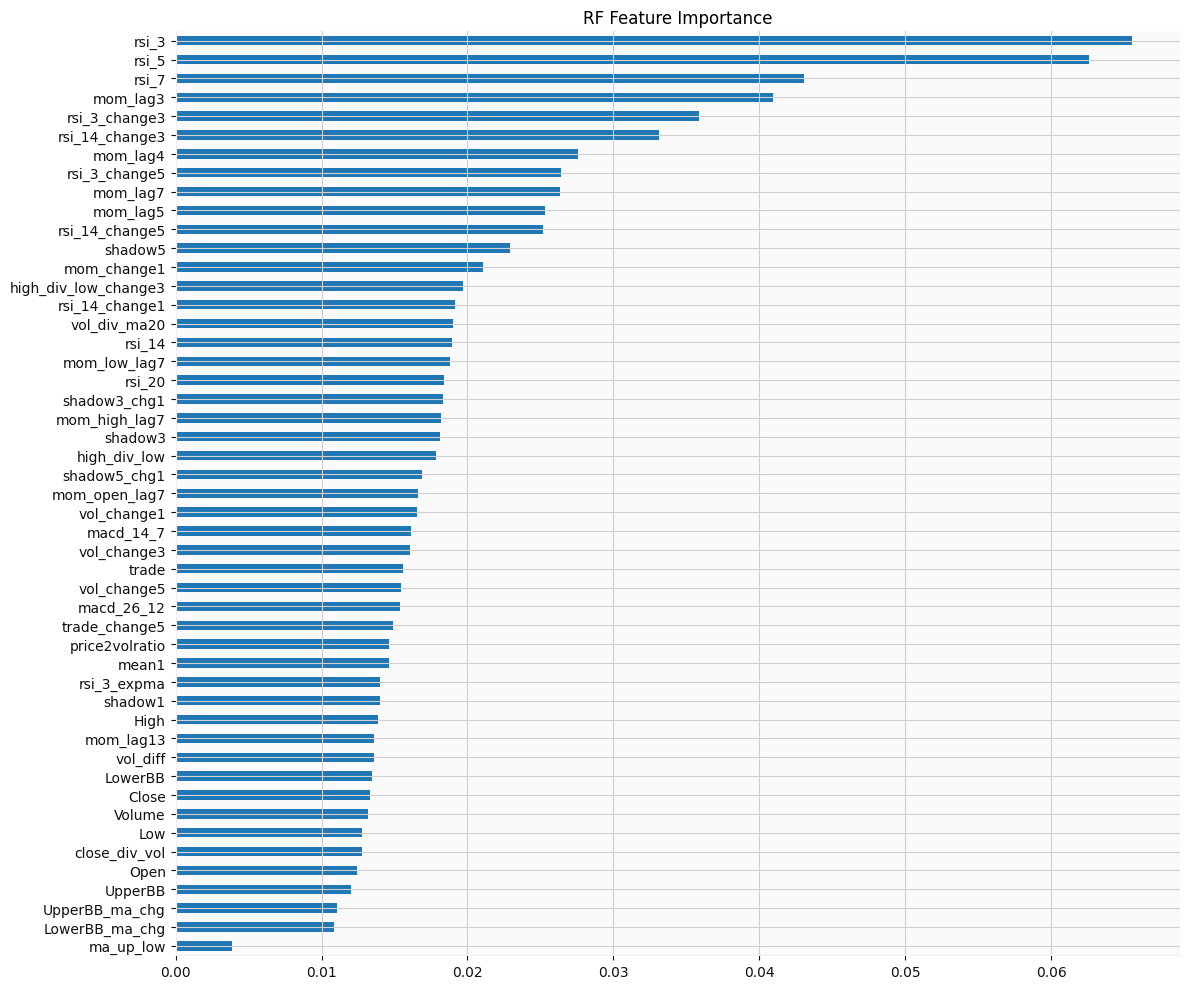

In [40]:

fig, ax = plt.subplots(figsize=(12,10))
(pd.Series(gridsearch_clf.best_estimator_.feature_importances_, 
           index=X.drop(columns=["date"]).columns)
 .sort_values(ascending=False)
 .iloc[:50]
 .sort_values()
 .plot.barh(ax=ax, title='RF Feature Importance'))
sns.despine()
fig.tight_layout();

In [41]:
roc_auc_score(y_test, gridsearch_clf.best_estimator_.predict(X_test.drop(columns="date")))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.3s finished


0.5526170885785757

(0.001, 2)

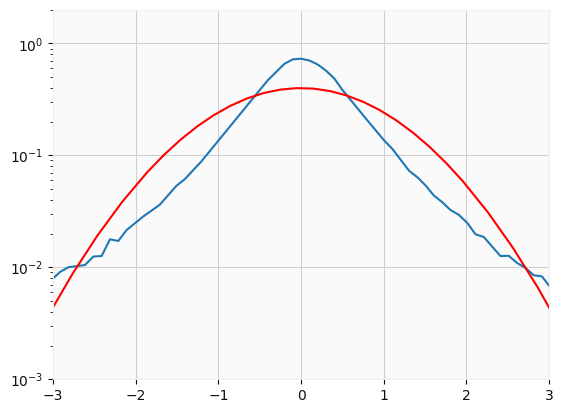

In [42]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats import norm
import matplotlib.mlab as mlab

scaler = StandardScaler()
log_rets = tu.log_return(crypto.candles["Close"]).dropna()

log_rets = log_rets.iloc[-150000:]

log_rets_norm = scaler.fit_transform(log_rets.values.reshape(-1, 1))

(mu, sigma) = norm.fit(log_rets_norm)

hist, bins = np.histogram(log_rets_norm,bins = np.linspace(-10,10,200) , density = True)

# the histogram of the data
#n, bins, patches = plt.hist(log_rets, bins = np.linspace(-0.2,0.2,200),density=True, facecolor='green', alpha=0.75)
bin_centers = 0.5*(bins[1:]+bins[:-1])

plt.plot(bin_centers,hist)

# add a 'best fit' line
x=np.linspace(-10,10,200)
plt.plot(x, norm.pdf(x, mu, sigma),color='r')
plt.yscale('log')

plt.xlim([-3, 3])
plt.ylim(1e-3,2)


In [43]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[int(result.size/2):]

autocorr_logret = autocorr(log_rets.values)

3319 150000


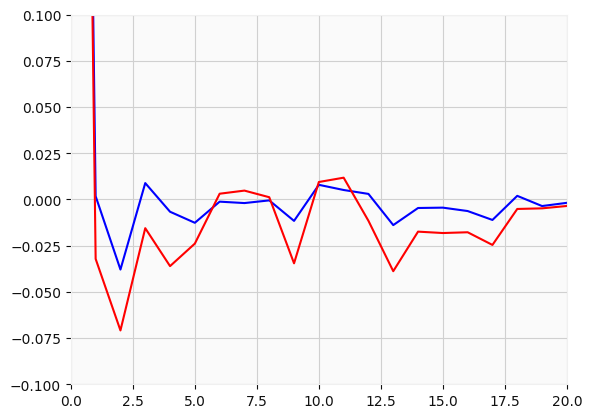

In [44]:
log_rets_norm = pd.Series(np.squeeze(log_rets_norm), index = log_rets.index, name="Close")
log_rets_res = log_rets_norm.reset_index()
upper_rets = (log_rets_res["Close"]  <-2.) #| (log_rets_res["Close"]  > 0.0)
indices_extreme = log_rets_res["Close"][upper_rets].index

log_rets_extreme = log_rets_res["Close"][upper_rets]

result = np.zeros_like(log_rets_extreme)
n = len(log_rets_extreme)

n = 40
result = np.zeros(n)

for lag in range(n):

    idx_in_bnd = indices_extreme + lag < len(log_rets)
    result[lag] = np.dot(log_rets_extreme.values[:np.sum(idx_in_bnd)], 
                    log_rets_res["Close"].iloc[(indices_extreme + lag)[idx_in_bnd]].values)

result/= result[0]

autocorr_logret /= autocorr_logret[0]
plt.plot(autocorr_logret, color = "b")
plt.plot(result,color = "r")

plt.ylim(-.1,.1)
plt.xlim(0,20)

print(len(log_rets_extreme), len(log_rets))

In [45]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import src.timeutils as tu

## Back-testing 

In [46]:
preds_clf = gridsearch_clf.best_estimator_.predict(X_test.drop(columns="date"))
preds_clf

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.5s finished


array([0., 0., 0., ..., 1., 1., 1.])

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.5s finished


`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44

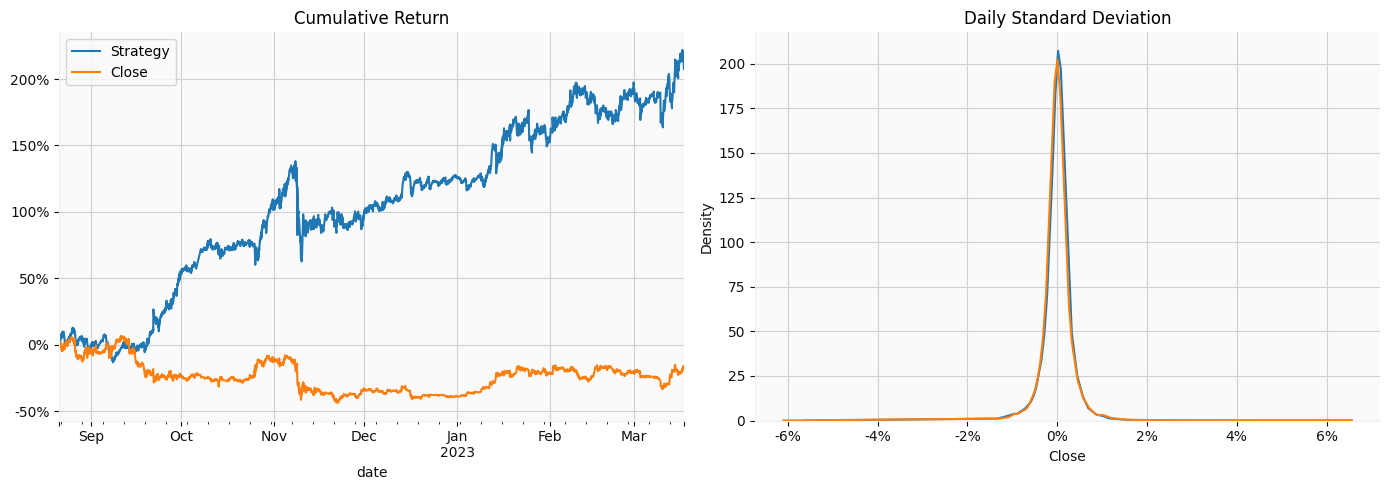

In [47]:
from matplotlib.ticker import FuncFormatter
import seaborn as sns


preds_clf = gridsearch_clf.best_estimator_.predict(X_test.drop(columns="date"))

fwd_rets = -1.*(X_test.set_index("date")["Close"].pct_change(-1))
y_preds = pd.Series(preds_clf, index = fwd_rets.index)

N_LONG = N_SHORT = 150
long_signals = ((y_preds.where(y_preds > 0.0)
                .rank(ascending=False) > N_LONG)
                .astype(int))
short_signals = ((y_preds.where(y_preds == 0.).rank()
                  > N_SHORT)
                 .astype(int))
long_returns = long_signals.mul(fwd_rets)
short_returns = short_signals.mul(-fwd_rets)
strategy = long_returns.add(short_returns).to_frame('Strategy')
fig, axes = plt.subplots(ncols=2, figsize=(14,5))
strategy.join(fwd_rets).add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Return')
sns.distplot(strategy.dropna(), ax=axes[1], hist=False, label='Strategy')
sns.distplot(fwd_rets, ax=axes[1], hist=False, label='BTCUSD')
axes[1].set_title('Daily Standard Deviation')
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
axes[1].xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
sns.despine()
fig.tight_layout();

In [48]:
y_preds

date
2022-08-21 09:30:00    0.0
2022-08-21 09:45:00    0.0
2022-08-21 10:00:00    0.0
2022-08-21 10:15:00    0.0
2022-08-21 10:30:00    0.0
                      ... 
2023-03-17 16:15:00    1.0
2023-03-17 16:30:00    1.0
2023-03-17 16:45:00    1.0
2023-03-17 17:00:00    1.0
2023-03-17 17:15:00    1.0
Length: 20000, dtype: float64

[[5205 4768]
 [4178 5849]]
Accuracy: 0.5527


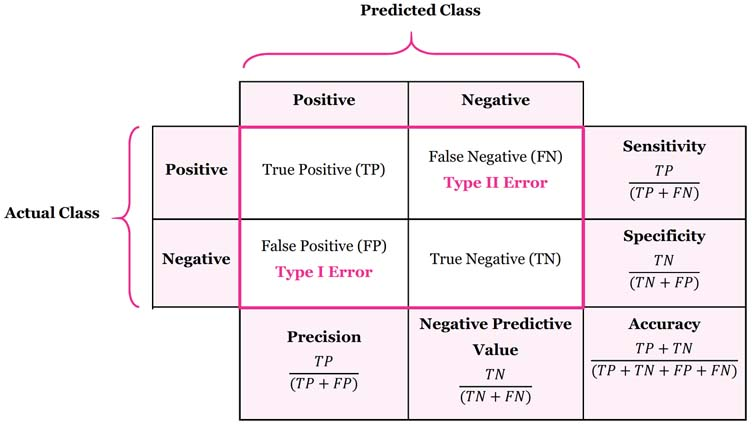

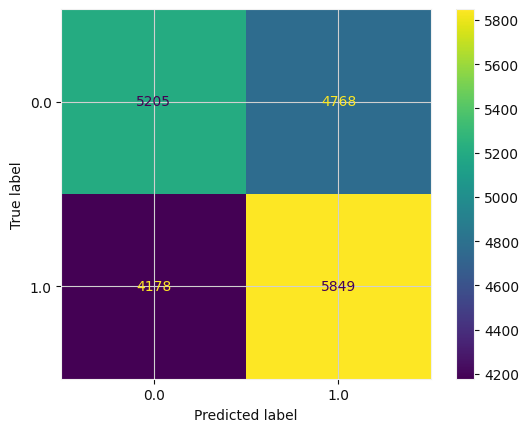

In [49]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


df_data = pd.concat([pd.Series(y_preds.values, index = y_test.index,name = "Predicted"),
                     y_test],axis=1)

cm = confusion_matrix(df_data["y"].dropna(), df_data["Predicted"].dropna())
print(cm)
print(f"Accuracy: {np.trace(cm)/np.sum(cm)}")
ConfusionMatrixDisplay.from_predictions( df_data["y"].dropna(), df_data["Predicted"].dropna())

from IPython.display import Image
Image('confusionMatrxiUpdated.jpg')

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.5s finished


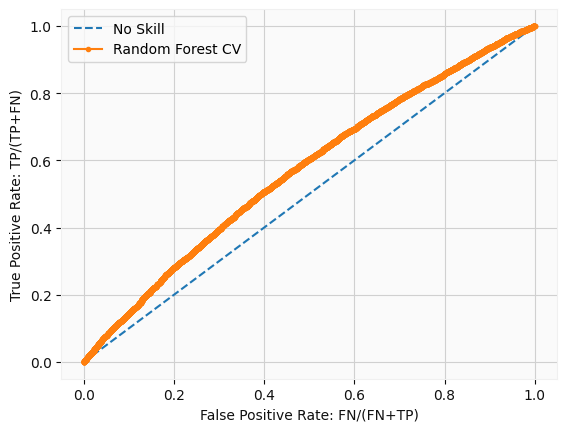

In [50]:
from sklearn.metrics import roc_curve

yhat = gridsearch_clf.best_estimator_.predict_proba(X_test.drop(columns="date"))

# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]
# plot no skill roc curve
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
# calculate roc curve for model
fpr, tpr, _ = roc_curve(y_test, pos_probs)
# plot model roc curve
plt.plot(fpr, tpr, marker='.', label='Random Forest CV')
# axis labels
plt.xlabel('False Positive Rate: FN/(FN+TP)')
plt.ylabel('True Positive Rate: TP/(TP+FN)')
# show the legend
plt.legend()
# show the plot
plt.show()


In [51]:
clf3 = xgb.XGBClassifier(
      n_estimators=100,
      max_depth=11,
      learning_rate=0.05,
      subsample=0.90,
      colsample_bytree=0.7,
      missing=-999,
      random_state=777,
      tree_method='gpu_hist',  # THE MAGICAL PARAMETER
      reg_alpha=10,
      reg_lambda=10,
    )
clf3.fit(X.set_index("date"), y)
roc_score_xgb = roc_auc_score(y_test, clf3.predict(X_test.drop(columns="date")))
print(roc_score_xgb)

0.5403872144227931


In [52]:
clf2 = xgb.XGBClassifier(
      n_estimators=100,
      max_depth=11,
      learning_rate=0.05,
      subsample=0.90,
      colsample_bytree=0.7,
      missing=-999,
      random_state=777,
      tree_method='gpu_hist',  # THE MAGICAL PARAMETER
      reg_alpha=10,
      reg_lambda=10,
    )
clf2.fit(X.set_index("date"), y)
roc_score_xgb = roc_auc_score(y_test, clf2.predict(X_test.drop(columns="date")))
print(roc_score_xgb)

0.5403872144227931


In [53]:
clf1 = xgb.XGBClassifier(
      n_estimators=100,
      max_depth=11,
      learning_rate=0.05,
      subsample=0.90,
      colsample_bytree=0.7,
      missing=-999,
      random_state=21,
      tree_method='gpu_hist',  # THE MAGICAL PARAMETER
      reg_alpha=10,
      reg_lambda=10,
    )

In [54]:
clf1.fit(X.set_index("date"), y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=11, max_leaves=None,
              min_child_weight=None, missing=-999, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=21, ...)

In [55]:
clf1.predict_proba(X_test.set_index("date"))[:,1]

array([0.3731431 , 0.46639892, 0.42306888, ..., 0.58604664, 0.5072848 ,
       0.51029176], dtype=float32)

In [56]:
roc_score_xgb = roc_auc_score(y_test, clf1.predict(X_test.drop(columns="date")))
print(roc_score_xgb)

0.5408707479477526


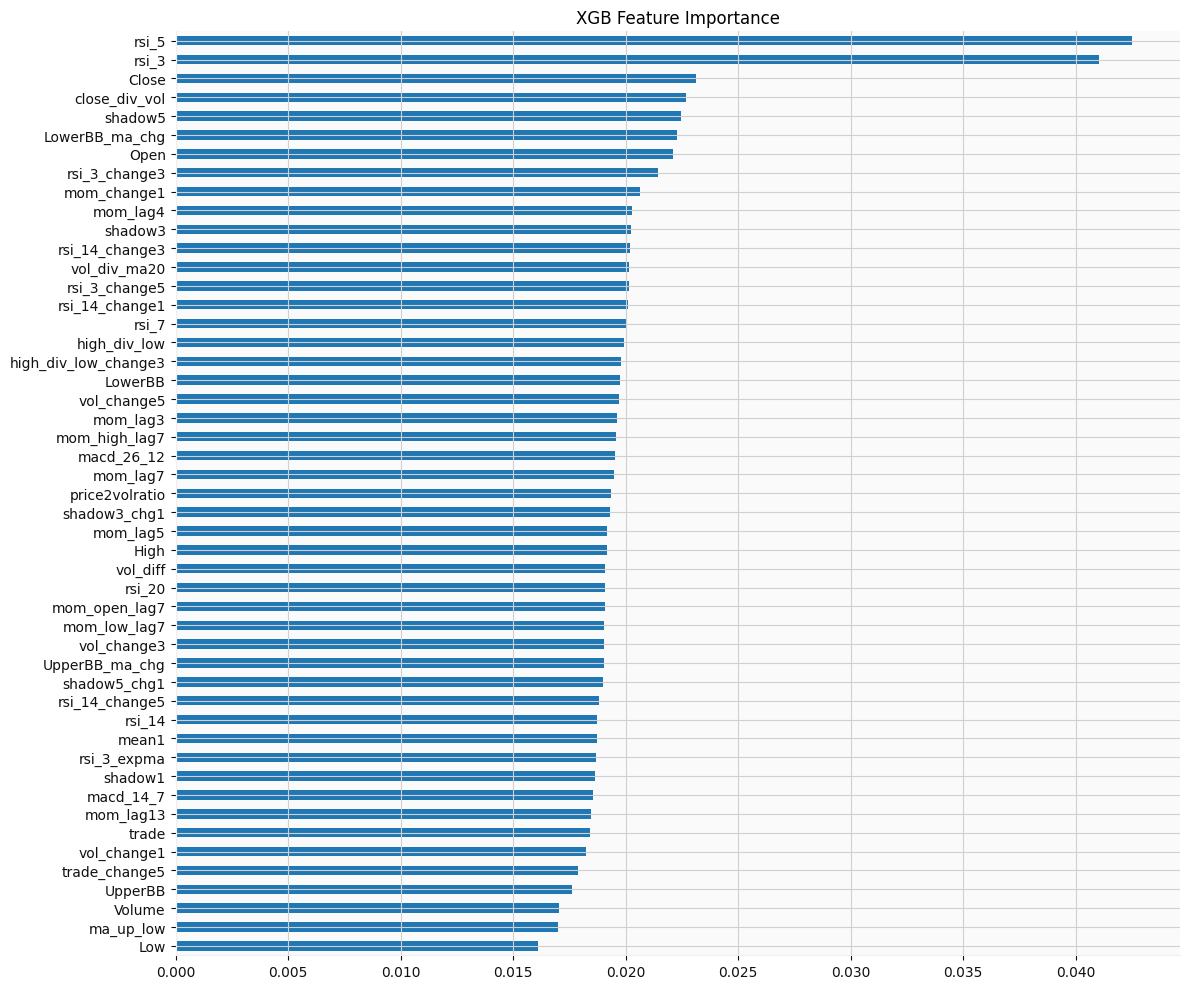

In [57]:
fig, ax = plt.subplots(figsize=(12,10))
(pd.Series(clf1.feature_importances_, 
           index=X.drop(columns=["date"]).columns)
 .sort_values(ascending=False)
 .iloc[:50]
 .sort_values()
 .plot.barh(ax=ax, title='XGB Feature Importance'))
sns.despine()
fig.tight_layout();

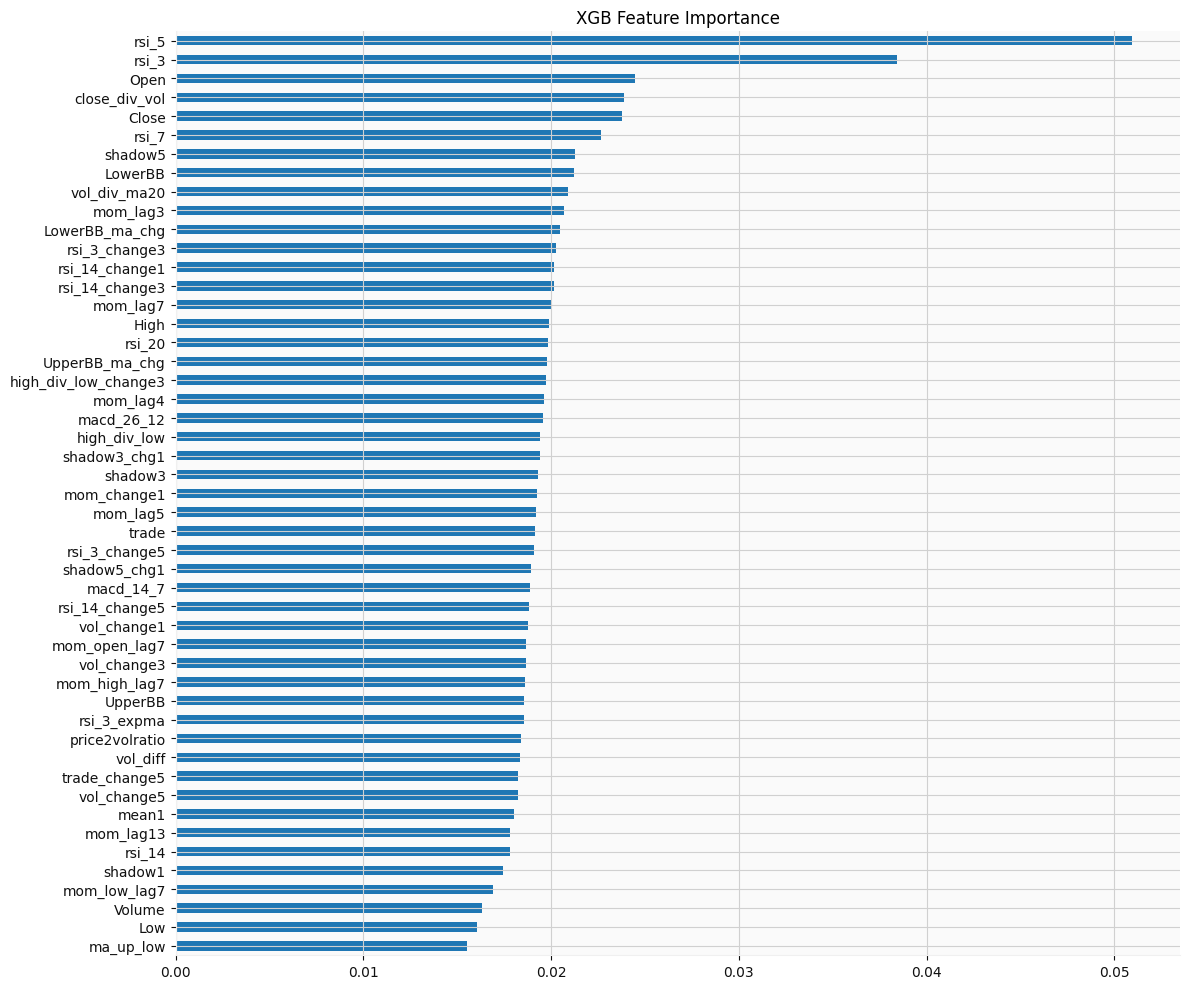

In [58]:
fig, ax = plt.subplots(figsize=(12,10))
(pd.Series(clf3.feature_importances_, 
           index=X.drop(columns=["date"]).columns)
 .sort_values(ascending=False)
 .iloc[:50]
 .sort_values()
 .plot.barh(ax=ax, title='XGB Feature Importance'))
sns.despine()
fig.tight_layout();



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



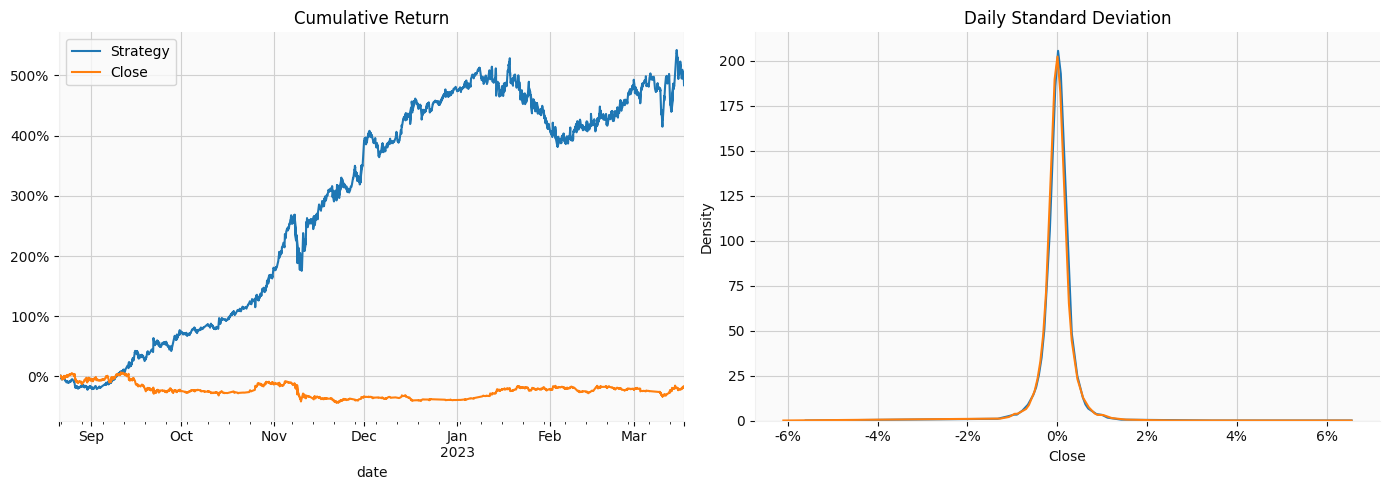

In [59]:

preds_clf = clf3.predict(X_test.drop(columns="date"))

#preds_clf = clf1.predict(X_test.iloc[-10000:].set_index("date").drop(columns=["Close","High","Open","Low","Volume","UpperBB","LowerBB"]))


fwd_rets = -1.*(X_test.set_index("date")["Close"].pct_change(-1))
y_preds = pd.Series(preds_clf, index = fwd_rets.index)

N_LONG = N_SHORT = 150
long_signals = ((y_preds.where(y_preds > 0.0)
                .rank(ascending=False) > N_LONG)
                .astype(int))
short_signals = ((y_preds.where(y_preds == 0.).rank()
                  > N_SHORT)
                 .astype(int))
long_returns = long_signals.mul(fwd_rets)
short_returns = short_signals.mul(-fwd_rets)
strategy = long_returns.add(short_returns).to_frame('Strategy')
fig, axes = plt.subplots(ncols=2, figsize=(14,5))
strategy.join(fwd_rets).add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Return')
sns.distplot(strategy.dropna(), ax=axes[1], hist=False, label='Strategy')
sns.distplot(fwd_rets, ax=axes[1], hist=False, label='BTCUSD')
axes[1].set_title('Daily Standard Deviation')
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
axes[1].xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
sns.despine()
fig.tight_layout();


In [60]:
preds_proba_ensembled = ((clf1.predict_proba(X_test.drop(columns="date"))[:,1] + \
clf3.predict_proba(X_test.drop(columns="date"))[:,1] + \
clf2.predict_proba(X_test.drop(columns="date"))[:,1])/3 + \
gridsearch_clf.best_estimator_.predict_proba(X_test.drop(columns="date"))[:,1])/2

preds_ensembled = (preds_proba_ensembled > 0.5).astype(int)
roc_score_xgb = roc_auc_score(y_test, preds_ensembled)

print(roc_score_xgb)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s


0.5481007706546182


[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.5s finished




`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



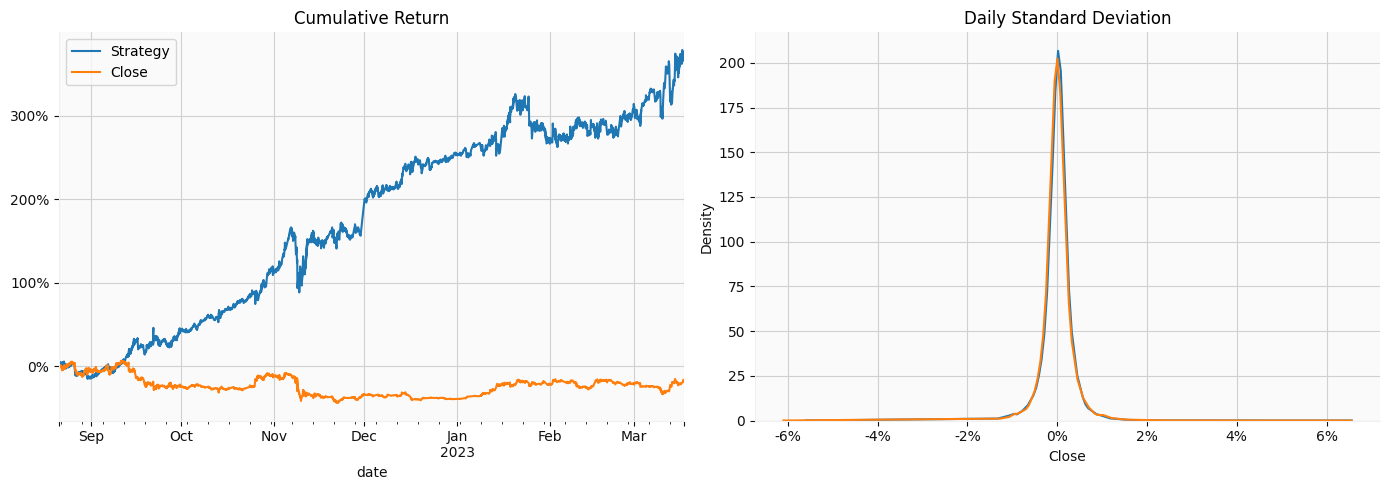

In [61]:

fwd_rets = -1.*(X_test.set_index("date")["Close"].pct_change(-1))
y_preds = pd.Series(preds_ensembled, index = fwd_rets.index)

N_LONG = N_SHORT = 150
long_signals = ((y_preds.where(y_preds > 0.0)
                .rank(ascending=False) > N_LONG)
                .astype(int))
short_signals = ((y_preds.where(y_preds == 0.).rank()
                  > N_SHORT)
                 .astype(int))
long_returns = long_signals.mul(fwd_rets)
short_returns = short_signals.mul(-fwd_rets)
strategy = long_returns.add(short_returns).to_frame('Strategy')
fig, axes = plt.subplots(ncols=2, figsize=(14,5))
strategy.join(fwd_rets).add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Return')
sns.distplot(strategy.dropna(), ax=axes[1], hist=False, label='Strategy')
sns.distplot(fwd_rets, ax=axes[1], hist=False, label='BTCUSD')
axes[1].set_title('Daily Standard Deviation')
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
axes[1].xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
sns.despine()
fig.tight_layout();

In [62]:
explainer_xgb = shap.TreeExplainer(clf1)
shap_values = explainer_xgb.shap_values(X=X_test.drop(columns = "date"))

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


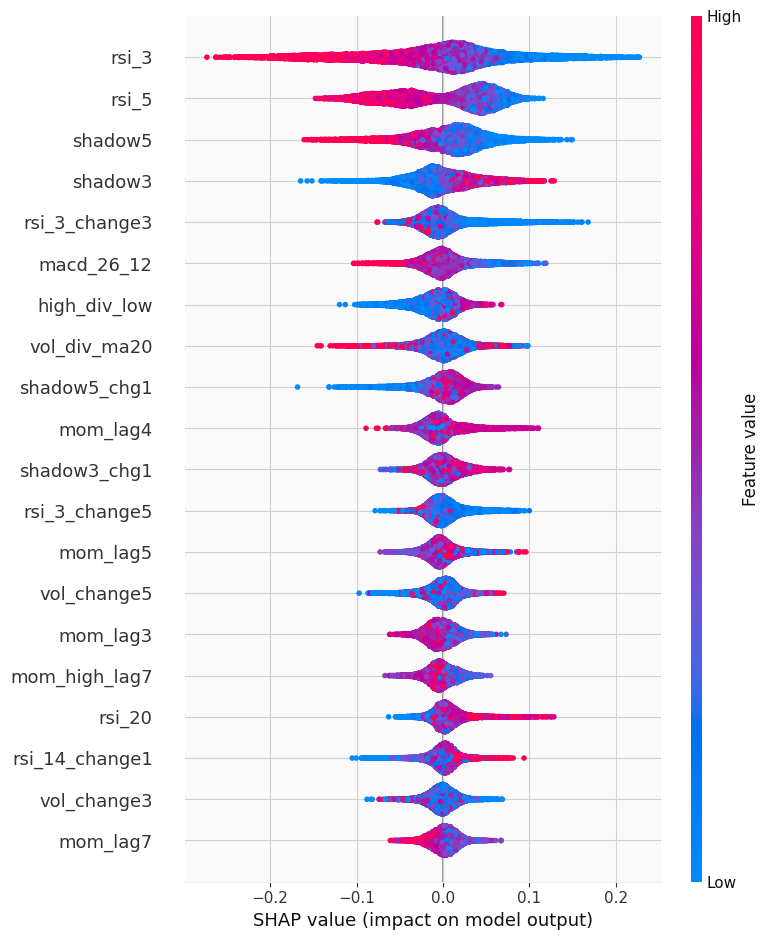

In [63]:
shap.summary_plot(shap_values, X_test.set_index("date"), show=False)
plt.tight_layout();

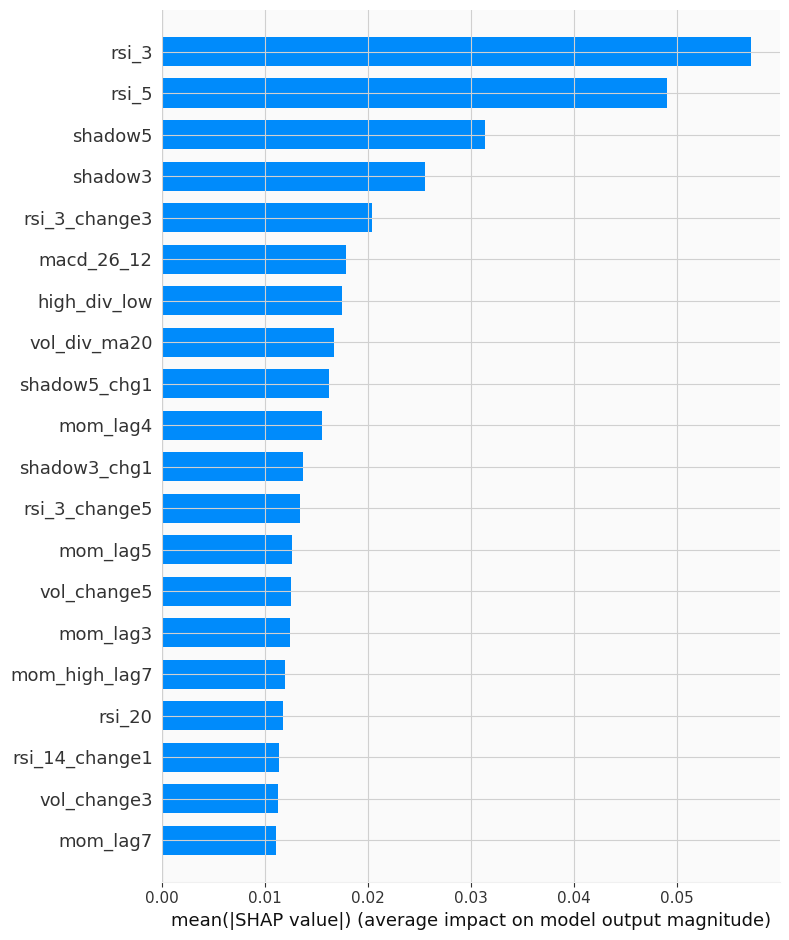

In [64]:
shap.summary_plot(shap_values, X_test.set_index("date"), plot_type="bar",show=False)
plt.tight_layout();

<Axes: xlabel='date'>

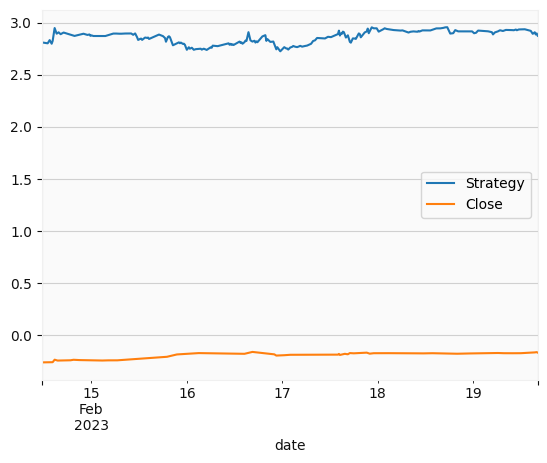

In [65]:
(strategy.join(fwd_rets).add(1).cumprod().sub(1)).iloc[-3000:-2500].plot()

In [66]:
shap.initjs()
i = np.random.randint(0, len(X_test.iloc[-3000:-2500].set_index("date")))
# visualize the first prediction's explanation
shap.force_plot(explainer_xgb.expected_value, shap_values[i,:], X_test.iloc[-3000:-2500].set_index("date").iloc[i,:])

In [67]:
SHOW_FORCE_PLOT = False
if SHOW_FORCE_PLOT:
  shap.initjs()
  # visualize the first prediction's explanation
  shap.force_plot(explainer_xgb.expected_value,  shap_values[:,:], X_test.set_index("date"))

In [68]:
cv_score = cross_val_score(estimator=clf1,
                           X=X.set_index("date"),
                           y=y,
                           scoring='roc_auc',
                           cv=cv,
                           n_jobs=-1,
                           verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   14.3s finished


In [69]:
param_grid = {'n_estimators': [ 100, 200 ],
              'max_depth': [10, 15],
              'min_samples_leaf': [ 100, 200]}

In [70]:
gridsearch_xgb_clf = GridSearchCV(estimator=clf1,
                              param_grid=param_grid,
                              scoring='roc_auc',
                              n_jobs=-1,
                              cv=cv,
                              refit=True,
                              return_train_score=True,
                              verbose=1)

In [71]:
gridsearch_xgb_clf.fit(X=X.set_index("date"), y=y)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
[17:46:29] WARNING: ../src/learner.cc:767: 
Parameters: { "min_samples_leaf" } are not used.



GridSearchCV(cv=<__main__.MultipleTimeSeriesCV object at 0x7efb94f86b20>,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.7,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=No...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=11,
                                     max_leaves=None, min_child_weight=None,
                                     missing=-999, monotone_constraints=None,
                                

In [72]:
print(gridsearch_xgb_clf.best_score_)

0.5512821657122323


In [73]:
roc_score = roc_auc_score(y_test, gridsearch_xgb_clf.best_estimator_.predict(X_test.drop(columns="date")))
print(roc_score)

0.5387977328354723


In [74]:
X_test_small = X_test[-10000:]



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



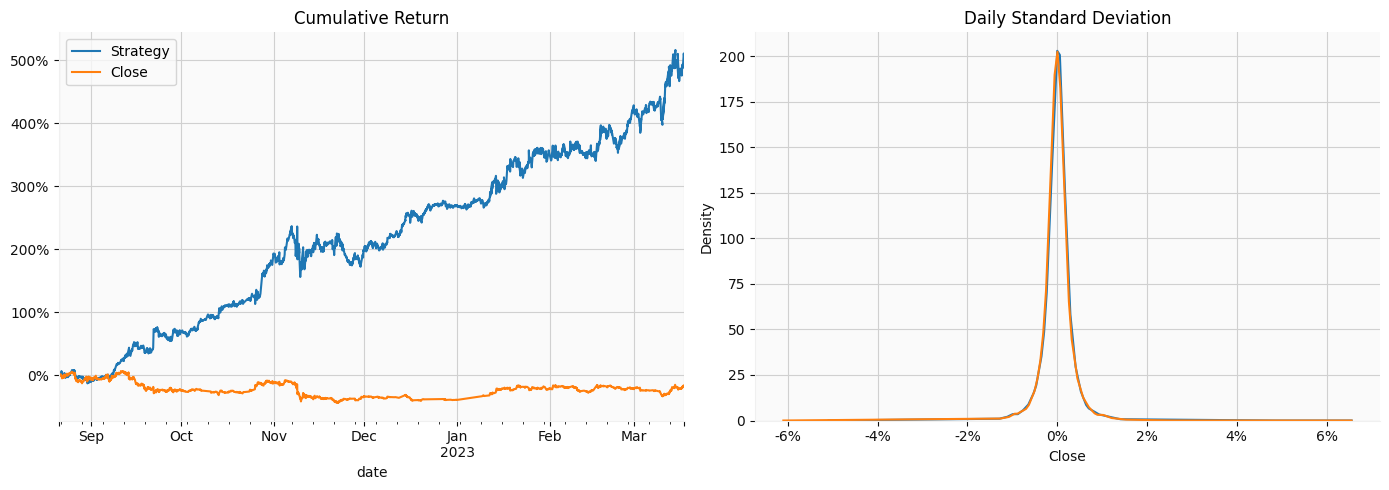

In [75]:
preds_clf = gridsearch_xgb_clf.best_estimator_.predict(X_test.drop(columns="date"))

#preds_clf = clf1.predict(X_test.iloc[-10000:].set_index("date").drop(columns=["Close","High","Open","Low","Volume","UpperBB","LowerBB"]))


fwd_rets = -1.*(X_test.set_index("date")["Close"].pct_change(-1))
y_preds = pd.Series(preds_clf, index = fwd_rets.index)

N_LONG = N_SHORT = 150
long_signals = ((y_preds.where(y_preds > 0.0)
                .rank(ascending=False) > N_LONG)
                .astype(int))
short_signals = ((y_preds.where(y_preds == 0.).rank()
                  > N_SHORT)
                 .astype(int))
long_returns = long_signals.mul(fwd_rets)
short_returns = short_signals.mul(-fwd_rets)
strategy = long_returns.add(short_returns).to_frame('Strategy')
fig, axes = plt.subplots(ncols=2, figsize=(14,5))
strategy.join(fwd_rets).add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Return')
sns.distplot(strategy.dropna(), ax=axes[1], hist=False, label='Strategy')
sns.distplot(fwd_rets, ax=axes[1], hist=False, label='BTCUSD')
axes[1].set_title('Daily Standard Deviation')
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
axes[1].xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
sns.despine()
fig.tight_layout();

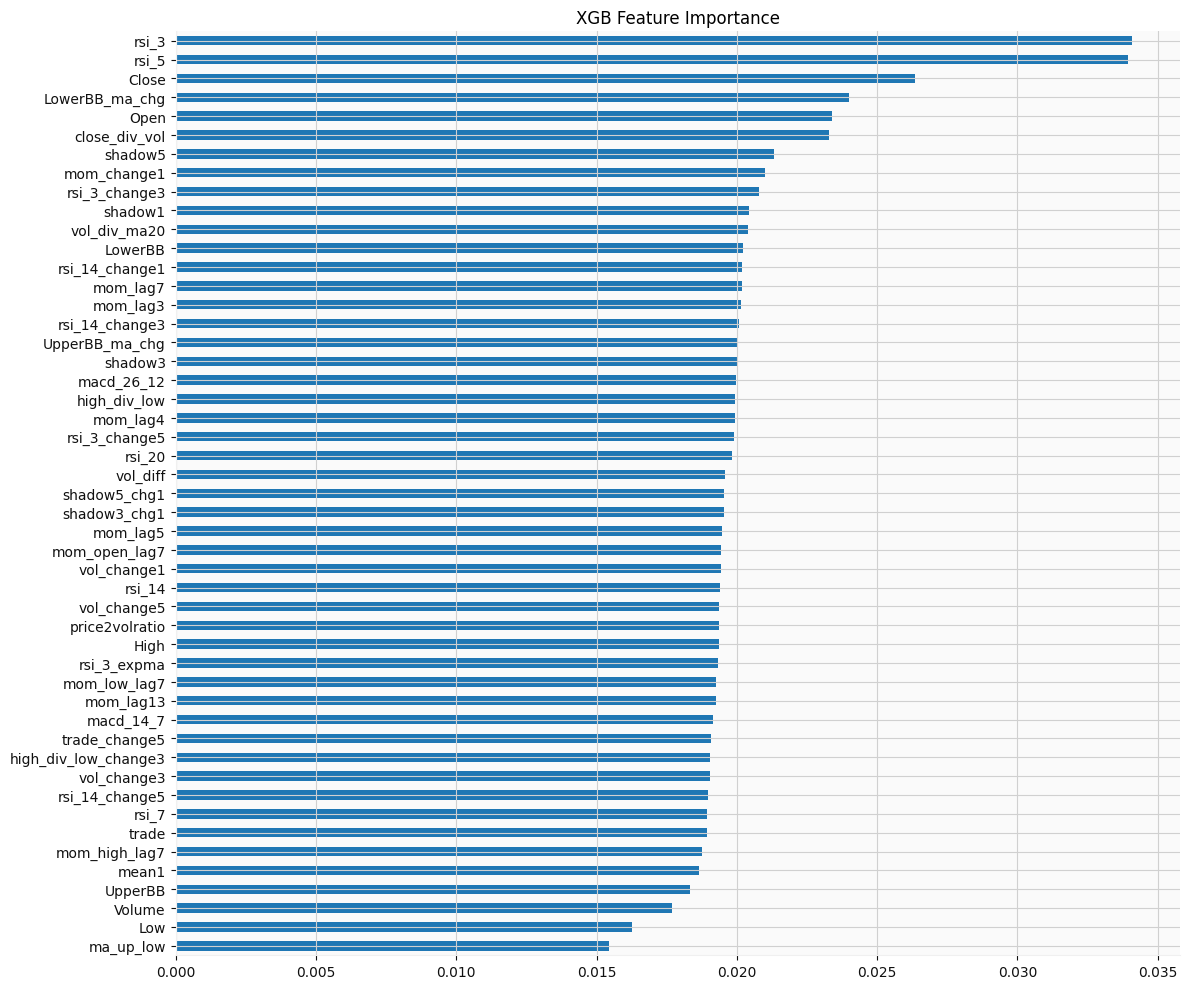

In [76]:
fig, ax = plt.subplots(figsize=(12,10))
(pd.Series(gridsearch_xgb_clf.best_estimator_.feature_importances_, 
           index=X.drop(columns=["date"]).columns)
 .sort_values(ascending=False)
 .iloc[:50]
 .sort_values()
 .plot.barh(ax=ax, title='XGB Feature Importance'))
sns.despine()
fig.tight_layout();

In [89]:
preds_proba_ensembled = (gridsearch_xgb_clf.best_estimator_.predict_proba(X_test.drop(columns="date"))[:,1] + \
gridsearch_clf.best_estimator_.predict_proba(X_test.drop(columns="date"))[:,1])/2

preds_ensembled = (preds_proba_ensembled > 0.5).astype(int)
roc_score_xgb = roc_auc_score(y_test, preds_ensembled)

print(roc_score_xgb)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s


0.547198064073887


[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.7s finished




`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



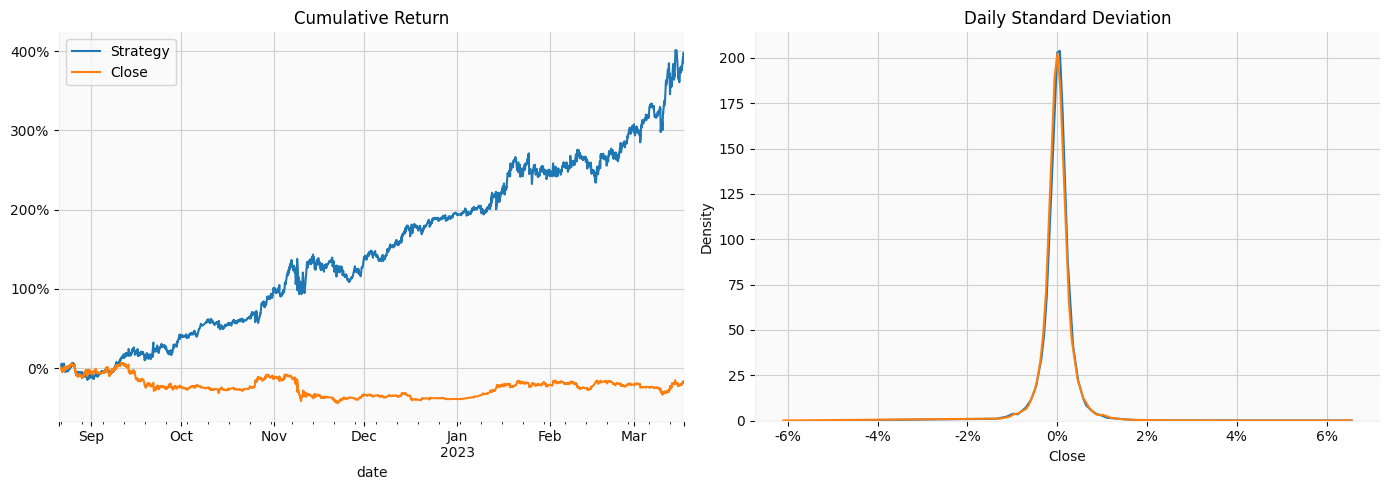

In [78]:

fwd_rets = -1.*(X_test.set_index("date")["Close"].pct_change(-1))
y_preds = pd.Series(preds_ensembled, index = fwd_rets.index)

N_LONG = N_SHORT = 150
long_signals = ((y_preds.where(y_preds > 0.0)
                .rank(ascending=False) > N_LONG)
                .astype(int))
short_signals = ((y_preds.where(y_preds == 0.).rank()
                  > N_SHORT)
                 .astype(int))
long_returns = long_signals.mul(fwd_rets)
short_returns = short_signals.mul(-fwd_rets)
strategy = long_returns.add(short_returns).to_frame('Strategy')
fig, axes = plt.subplots(ncols=2, figsize=(14,5))
strategy.join(fwd_rets).add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Return')
sns.distplot(strategy.dropna(), ax=axes[1], hist=False, label='Strategy')
sns.distplot(fwd_rets, ax=axes[1], hist=False, label='BTCUSD')
axes[1].set_title('Daily Standard Deviation')
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
axes[1].xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
sns.despine()
fig.tight_layout();

[[4896 5077]
 [3976 6051]]
Accuracy: 0.54735


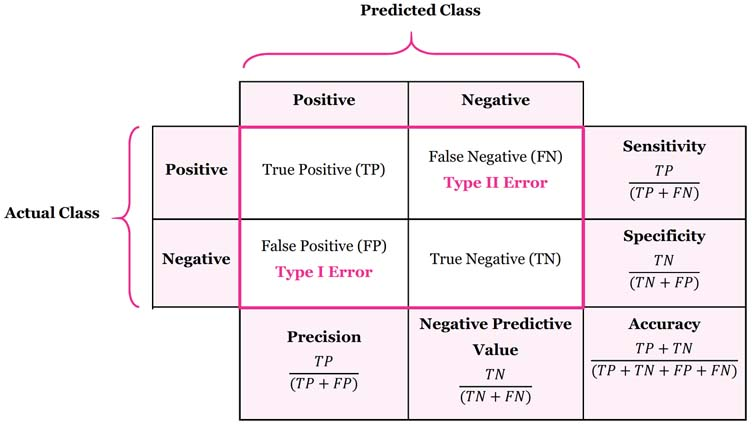

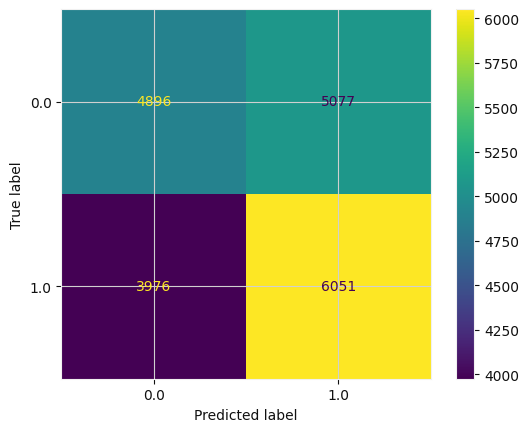

In [79]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

df_data = pd.concat([pd.Series(y_preds.values, index = y_test.index,name = "Predicted"),
                     y_test],axis=1)

cm = confusion_matrix(df_data["y"].dropna(), df_data["Predicted"].dropna())
print(cm)
print(f"Accuracy: {np.trace(cm)/np.sum(cm)}")
ConfusionMatrixDisplay.from_predictions( df_data["y"].dropna(), df_data["Predicted"].dropna())

from IPython.display import Image
Image('confusionMatrxiUpdated.jpg')

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.6s finished


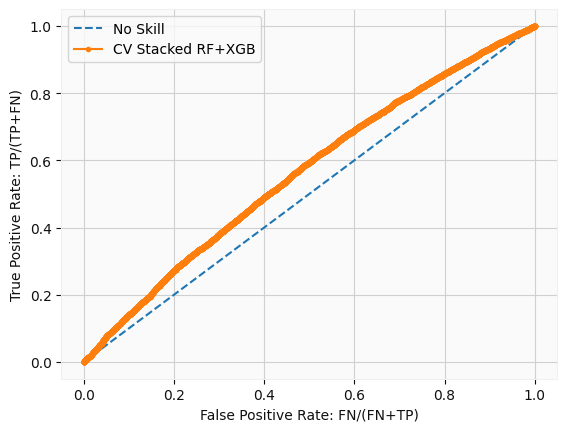

ROC AUC Score: 0.547198064073887


In [90]:

yhat = (gridsearch_xgb_clf.best_estimator_.predict_proba(X_test.drop(columns="date"))[:,1] + \
gridsearch_clf.best_estimator_.predict_proba(X_test.drop(columns="date"))[:,1])/2

# plot no skill roc curve
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
# calculate roc curve for model
fpr, tpr, _ = roc_curve(y_test, yhat)
# plot model roc curve
plt.plot(fpr, tpr, marker='.', label='CV Stacked RF+XGB')
# axis labels
plt.xlabel('False Positive Rate: FN/(FN+TP)')
plt.ylabel('True Positive Rate: TP/(TP+FN)')
# show the legend
plt.legend()
# show the plot
plt.show()

preds_ensembled = (preds_proba_ensembled > 0.5).astype(int)
roc_score = roc_auc_score(y_test, preds_ensembled)

print(f'ROC AUC Score: {roc_score}')


In [91]:
from joblib import dump, load
dump(gridsearch_clf.best_estimator_, f'model/rf_clf_roc_score_{roc_score:.4f}_{crypto_name}.joblib')
dump(gridsearch_xgb_clf.best_estimator_, f'model/xgb_clf_roc_score_{roc_score:.4f}_{crypto_name}.joblib')


['model/xgb_clf_roc_score_0.5472_Ethereum.joblib']

In [92]:
with open(f'model/rf_clf_roc_score_{roc_score:.4f}_{crypto_name}.txt', 'w') as f:
    for line in list(X.columns.values):
        f.write(f"{line}\n")

In [93]:
prev_score = 0.5472
rf_clf = load(f'model/rf_clf_roc_score_{prev_score}_{crypto_name}.joblib') 
xgb_clf = load(f'model/xgb_clf_roc_score_{prev_score}_{crypto_name}.joblib') 